# Preprocessing

In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report

import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
import gensim.downloader as api

In [30]:
fasttext_model = api.load("fasttext-wiki-news-subwords-300") # Download pretrained model
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nikolay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/nikolay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [44]:
CLASS = 'Discussion'
DATA_SAVE_PATH = f"./data/cleaned_data.csv"
CONTEXT = True
HISTORY = False
USE_TEXT = 'message'

REMOVE_STOPWORDS = True
REMOVE_NUM = False

other_classes_to_predict = ['Discussion', 'Dialogic Spell', 'Uptake', 'Question', 'Pivot']
other_classes_to_predict.remove(CLASS)
remove_also = ['topic']
remove_also += other_classes_to_predict

In [45]:
def preprocess_text(text):
    # Tokenization, lowercasing, removing stopwords, etc.
    tokens = [word.lower() for word in nltk.word_tokenize(text)]
    
    if REMOVE_NUM:
        tokens = [word for word in tokens if word.isalpha()]

    if REMOVE_STOPWORDS:
        tokens = [word for word in tokens if word not in stop_words]

    return ' '.join(tokens)

data = pd.read_csv(DATA_SAVE_PATH)
data[USE_TEXT] = data[USE_TEXT].apply(preprocess_text)
data.drop(columns=remove_also, inplace=True)

if not CONTEXT:
    data = data[[USE_TEXT, CLASS]]


In [46]:
# Convert text data into numerical vectors using FastText word embeddings
def get_embedding(text):
    # Initialize an empty vector
    vector = np.zeros(300)
    # Iterate over each word in the text
    for word in text.split():
        # If the word is in the FastText vocabulary, add its embedding to the vector
        if word in fasttext_model:
            vector += fasttext_model[word]
        else:
            print(f"Word '{word}' not in vocabulary")
    # Return the vector
    return vector

mess_embeddings = pd.DataFrame(data[USE_TEXT].apply(get_embedding).tolist())

data = pd.concat([data, mess_embeddings], axis=1)

Word '''' not in vocabulary
Word '''' not in vocabulary
Word 'n't' not in vocabulary
Word 'n't' not in vocabulary
Word 'ashely' not in vocabulary
Word '``' not in vocabulary
Word '''' not in vocabulary
Word 'orgininally' not in vocabulary
Word 'thoughts/suggestions' not in vocabulary
Word 'uwgyeu' not in vocabulary
Word '''' not in vocabulary
Word '``' not in vocabulary
Word '''' not in vocabulary
Word '''' not in vocabulary
Word 'kyra' not in vocabulary
Word 'emilie' not in vocabulary
Word 'n't' not in vocabulary
Word '``' not in vocabulary
Word '''' not in vocabulary
Word 'n't' not in vocabulary
Word 'n't' not in vocabulary
Word 'n't' not in vocabulary
Word 'lis6303' not in vocabulary
Word 'lis6303' not in vocabulary
Word 'emilie' not in vocabulary
Word 'kyra' not in vocabulary
Word 'n't' not in vocabulary
Word 'kyra' not in vocabulary
Word ''my' not in vocabulary
Word 'n't' not in vocabulary
Word 'n't' not in vocabulary
Word 'darla' not in vocabulary
Word 'experien' not in vocabular

In [47]:
y = data[CLASS].fillna('None')
if CONTEXT:
    data['course'] = LabelEncoder().fit_transform(data['course'])
    data['book_id'] = data['book_id'].astype(int)
    data['bookclub'] = data['bookclub'].astype(int)
    data['chat_crew'] = data['chat_crew'].astype(bool)
    data['pseudonym'] = LabelEncoder().fit_transform(data['pseudonym'])

    data['time'] = pd.to_datetime(data['time'], errors='coerce')

    data['year'] = data['time'].dt.year
    data['month'] = data['time'].dt.month
    data['day'] = data['time'].dt.day
    data['hour'] = data['time'].dt.hour
    data['minute'] = data['time'].dt.minute
    data['second'] = data['time'].dt.second

    data['page'] = data['page'].fillna(0).astype(int)
    data['response_number'] = data['response_number'].fillna(0).astype(float)

    data.drop(columns=['time', 'message', CLASS], inplace=True)
else:
    data.drop(columns=['message', CLASS], inplace=True)

In [48]:
data

,course,book_id,bookclub,chat_crew,pseudonym,is_answer,page,response_number,0,1,...,296,297,298,299,year,month,day,hour,minute,second
0,1,260,1,True,67,False,10,3.1,-0.031234,0.049419,...,0.066292,0.046231,-0.012138,0.030565,2020.0,10.0,20.0,17.0,6.0,0.0
1,1,260,1,True,67,False,10,3.1,-0.012513,0.045208,...,0.018545,-0.095000,-0.009200,-0.000744,2020.0,10.0,20.0,17.0,6.0,0.0
2,1,260,1,True,67,False,10,3.1,0.023686,0.000210,...,0.160402,0.128757,-0.210666,0.010261,2020.0,10.0,20.0,17.0,6.0,0.0
3,1,260,1,True,69,False,10,3.1,-0.007433,-0.016271,...,0.033206,-0.028945,0.146593,-0.080365,2020.0,10.0,27.0,17.0,58.0,0.0
4,1,260,1,True,69,False,10,3.1,-0.004315,-0.103644,...,0.236626,-0.185515,-0.119007,-0.001828,2020.0,10.0,27.0,17.0,58.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,4,306,7,True,3,False,3,0.0,-0.017933,-0.249814,...,0.068942,0.043535,0.021323,-0.106796,2022.0,3.0,1.0,15.0,21.0,13.0
901,4,306,7,True,20,False,2,0.0,0.060934,0.084670,...,-0.051192,0.125032,0.073620,-0.170250,2022.0,3.0,1.0,15.0,21.0,50.0
902,4,306,7,True,20,False,2,0.0,0.163171,0.091426,...,0.198589,-0.260083,-0.024904,-0.386629,2022.0,3.0,1.0,15.0,22.0,32.0
903,4,306,7,True,3,False,3,0.0,0.076193,0.023702,...,-0.010216,-0.081569,0.051319,0.000576,2022.0,3.0,1.0,15.0,22.0,56.0


In [49]:
# Convert labels to numerical labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42, stratify=y)

In [51]:
# Train an XGBoost classifier
xgb_classifier = XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_))
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=7,
              num_parallel_tree=None, ...)

In [52]:
# Predict on the test set
y_pred = xgb_classifier.predict(X_test)

# Evaluate the model
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='weighted', zero_division=0))
print('Recall:', recall_score(y_test, y_pred, average='weighted', zero_division=0))
print('F1:', f1_score(y_test, y_pred, average='weighted', zero_division=0))

print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0))

Accuracy: 0.7071823204419889
Precision: 0.6758314375473946
Recall: 0.7071823204419889
F1: 0.6853961553785025
                   precision    recall  f1-score   support

     Deliberation       0.60      0.67      0.63        45
Imaginative Entry       0.00      0.00      0.00         6
            Other       0.00      0.00      0.00         2
        Procedure       0.60      0.46      0.52        13
          Seminar       0.76      0.88      0.82        89
           Social       0.80      0.50      0.62        16
               UX       0.67      0.60      0.63        10

         accuracy                           0.71       181
        macro avg       0.49      0.44      0.46       181
     weighted avg       0.68      0.71      0.69       181



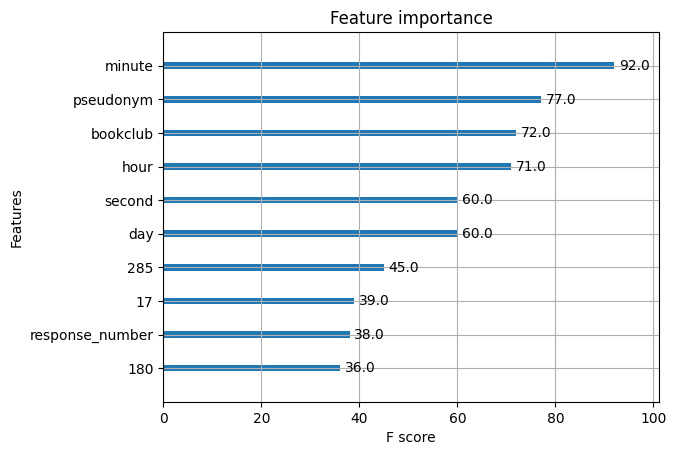

In [54]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming xgb_classifier is your trained model
xgb.plot_importance(xgb_classifier, max_num_features=10)

plt.savefig("overfit.pdf")